In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import itertools

### Little bit of data preprocessing. Rest happens inside cross validation function

In [2]:
data = pd.read_csv('../data/SMSSpamCollection', sep='\t', header=None)
data['Text'] = data[1].str.replace('[^\w\s]','')
data.columns = ['label', 'Full Text', 'Text']
data['Lower Case Text'] = data['Text'].str.lower()

In [3]:
labels, counts = np.unique(data['label'], return_counts=True)
encoder = preprocessing.LabelEncoder()
encoder.fit(labels[np.argsort(-counts)])
data['y'] = encoder.transform(data['label'])

In [4]:
np.random.seed(42)
mask_train = np.random.random(data.shape[0]) < 0.8
data_train = data[mask_train]
data_test = data.iloc[~mask_train, :]

### Load word2vec stuff

In [5]:
#up sample data train for word2vec vocabulary
countToIncrease_word = data_train[data_train['y'] == 0].shape[0] - data_train[data_train['y'] == 1].shape[0]
spamupsampled_word = data_train[data_train['y'] == 1].sample(n=countToIncrease_word, replace=True)
data_train_upsample_word2vec = pd.concat([spamupsampled_word, data_train])

In [6]:
count_vect_sing_word = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
count_vect_sing_word.fit(data_train_upsample_word2vec['Lower Case Text'])
tokenizer_word = count_vect_sing_word.build_tokenizer()

In [7]:
VOCAB_SIZE = len(count_vect_sing_word.vocabulary_)
EMBEDDING_SIZE = 300
word_to_ix = count_vect_sing_word.vocabulary_

In [8]:
class TwoGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(TwoGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [9]:
CONTEXT_SIZE = 1
EMBEDDING_DIM = EMBEDDING_SIZE

In [10]:
word2vec_model = TwoGramLanguageModeler(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE)

In [11]:
MODEL_PATH = '../data/word_2vec_model'
word_embeddings = word2vec_model.embeddings
word2vec_model.load_state_dict(torch.load(MODEL_PATH))
word2vec_model.eval()

TwoGramLanguageModeler(
  (embeddings): Embedding(8111, 300)
  (linear1): Linear(in_features=300, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=8111, bias=True)
)

In [12]:
# count_vect_sing_word is a CountVectorizer
def _indicesForSentence(input_str, tokenizer = tokenizer_word, count_vect = count_vect_sing_word):
    input_str = list(filter(lambda x: x in count_vect.vocabulary_, tokenizer(input_str)))
    return torch.tensor([[word_to_ix[word]] for word in input_str], dtype=torch.long)

def getEmbedding(word_index_tensor, embedder):
    embedder(word_index_tensor)
def sentenceToNumpyInstance(input_str, embedder):
    embeddings = embedder(_indicesForSentence(input_str))
    if embeddings.shape == torch.Size([0]):
        return np.zeros(EMBEDDING_SIZE)
    else:
        x = torch.sum(embeddings, dim = 0)
        return torch.Tensor.numpy(x.detach())[0]
    
def word2vec_transform(data, embeddings, field = 'Lower Case Text'):
    return np.array(data[field].apply(sentenceToNumpyInstance, embedder=embeddings).values.tolist())

### Ending of Word2Vec initialization

### Cross-Validation

In [13]:
# dataset is supposed to be the normal trained data
## vectorizer is supposed to be the constructor
def crossval(dataset, model_func, parametersModel, embeddings = word_embeddings, vectorizer = None, 
             label_name = 'y', text_field = 'Lower Case Text', k_folds = 5): 
    aucs = {}
    folds = list(KFold(n_splits=k_folds).split(dataset))
    for fold in range(k_folds):
        cv_train = dataset.iloc[folds[fold][0]]
        cv_validate = dataset.iloc[folds[fold][1]]
    
        countToIncrease = cv_train[cv_train['y'] == 0].shape[0] - cv_train[cv_train['y'] == 1].shape[0]
        spamupsampled = cv_train[cv_train['y'] == 1].sample(n=countToIncrease, replace=True)
        cv_train = pd.concat([spamupsampled, cv_train])
        
        if vectorizer is not None:
            cv_train_features = vectorizer.fit_transform(cv_train[text_field])
            cv_train_y = cv_train[label_name]
            cv_validate_features = vectorizer.transform(cv_validate[text_field])
            cv_validate_y = cv_validate[label_name]
        else:
            # LOAD word to vec
            cv_train_features = word2vec_transform(cv_train, embeddings)
            cv_train_y = cv_train[label_name]
            cv_validate_features = word2vec_transform(cv_validate, embeddings)
            cv_validate_y = cv_validate[label_name]
        
        keys, values = zip(*parametersModel.items())
                
        for v in itertools.product(*values):    
            experiment = dict(zip(keys, v))
            m = model_func(**experiment)

            m.fit(cv_train_features, cv_train_y)
            y_preds = m.predict_proba(cv_validate_features)[:, 1]
            fpr, tpr, threshold = metrics.roc_curve(cv_validate_y, y_preds)
            auc_val = metrics.auc(fpr, tpr)  
            
            inside_key = ""

            for e in experiment:
                inside_key = inside_key + "_" + e + ':' + str(experiment[e])
            
            if not inside_key in aucs:
                aucs[inside_key] = []
                aucs[inside_key].append(auc_val)
            else:
                aucs[inside_key].append(auc_val)
    return aucs

In [14]:
LR_parameters = {'penalty': ['l1', 'l2'], 'C': [1, 5, 10]}

count_vect = CountVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS)
tfidf_vect = TfidfVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS)
bigram_count_vect = CountVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS, ngram_range = (2,2))
bigram_tfidf_vect = TfidfVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS, ngram_range = (2,2))
ngram_count_vect = CountVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS, ngram_range = (1,2))
ngram_tfidf_vect = TfidfVectorizer(min_df=2, stop_words=ENGLISH_STOP_WORDS, ngram_range = (1,2))

In [15]:
aucs_count_default = crossval(data_train, LogisticRegression, LR_parameters, vectorizer = count_vect)

In [16]:
aucs_tfidf_default = crossval(data_train, LogisticRegression, LR_parameters, vectorizer = tfidf_vect)

In [17]:
aucs_count_bigram = crossval(data_train, LogisticRegression, LR_parameters, vectorizer = bigram_count_vect)

In [18]:
aucs_tfidf_bigram = crossval(data_train, LogisticRegression, LR_parameters, vectorizer = bigram_tfidf_vect)

In [19]:
aucs_count_ngram = crossval(data_train, LogisticRegression, LR_parameters, vectorizer = ngram_count_vect)

In [20]:
aucs_tfidf_ngram = crossval(data_train, LogisticRegression, LR_parameters, vectorizer = ngram_tfidf_vect)

In [21]:
# defaults to word 2 vec
aucs_word_2_vec = crossval(data_train, LogisticRegression, LR_parameters, vectorizer = None)

In [22]:
def processAUCsResults(aucs_dict):
    aucs = {}
    max_auc = -1
    confs = ""
    for e in aucs_dict:
        mean_auc = np.mean(aucs_dict[e])
        aucs['LR'+ e] = mean_auc
        if mean_auc >= max_auc:
            confs = e
            max_auc = mean_auc
    return aucs, 'Parameters with max AUC: {}'.format(confs)

In [23]:
print(processAUCsResults(aucs_count_default))

({'LR_penalty:l1_C:1': 0.9773236078929284, 'LR_penalty:l1_C:5': 0.9811967581388616, 'LR_penalty:l1_C:10': 0.9822157110149817, 'LR_penalty:l2_C:1': 0.9889649363700389, 'LR_penalty:l2_C:5': 0.989242491721642, 'LR_penalty:l2_C:10': 0.9892710516402273}, 'Parameters with max AUC: _penalty:l2_C:10')


In [24]:
print(processAUCsResults(aucs_tfidf_default))

({'LR_penalty:l1_C:1': 0.9765655450930384, 'LR_penalty:l1_C:5': 0.9792745496947879, 'LR_penalty:l1_C:10': 0.9796767743258087, 'LR_penalty:l2_C:1': 0.9886230964977036, 'LR_penalty:l2_C:5': 0.9896713875234973, 'LR_penalty:l2_C:10': 0.9898372840630074}, 'Parameters with max AUC: _penalty:l2_C:10')


In [25]:
print(processAUCsResults(aucs_count_bigram))

({'LR_penalty:l1_C:1': 0.8804155376953771, 'LR_penalty:l1_C:5': 0.8881267930829244, 'LR_penalty:l1_C:10': 0.8894839412036616, 'LR_penalty:l2_C:1': 0.9454633349453758, 'LR_penalty:l2_C:5': 0.9454256474566112, 'LR_penalty:l2_C:10': 0.9456754610212901}, 'Parameters with max AUC: _penalty:l2_C:10')


In [26]:
print(processAUCsResults(aucs_tfidf_bigram))

({'LR_penalty:l1_C:1': 0.8816506830018062, 'LR_penalty:l1_C:5': 0.8886509161997713, 'LR_penalty:l1_C:10': 0.8907513828262168, 'LR_penalty:l2_C:1': 0.9445047820735075, 'LR_penalty:l2_C:5': 0.9442792840158292, 'LR_penalty:l2_C:10': 0.945394088013553}, 'Parameters with max AUC: _penalty:l2_C:10')


In [27]:
print(processAUCsResults(aucs_count_ngram))

({'LR_penalty:l1_C:1': 0.977876295635333, 'LR_penalty:l1_C:5': 0.9803703653650471, 'LR_penalty:l1_C:10': 0.9821558683472638, 'LR_penalty:l2_C:1': 0.989369208823606, 'LR_penalty:l2_C:5': 0.9899661401496254, 'LR_penalty:l2_C:10': 0.9901976985866373}, 'Parameters with max AUC: _penalty:l2_C:10')


In [28]:
print(processAUCsResults(aucs_tfidf_ngram))

({'LR_penalty:l1_C:1': 0.9739376625963034, 'LR_penalty:l1_C:5': 0.9778216261204793, 'LR_penalty:l1_C:10': 0.977672444615731, 'LR_penalty:l2_C:1': 0.9858649183438238, 'LR_penalty:l2_C:5': 0.98763164865167, 'LR_penalty:l2_C:10': 0.9879518962811862}, 'Parameters with max AUC: _penalty:l2_C:10')


In [29]:
print(processAUCsResults(aucs_word_2_vec))

({'LR_penalty:l1_C:1': 0.9261876868115941, 'LR_penalty:l1_C:5': 0.9221642388573885, 'LR_penalty:l1_C:10': 0.921373936391967, 'LR_penalty:l2_C:1': 0.9261794908199436, 'LR_penalty:l2_C:5': 0.9238146489516403, 'LR_penalty:l2_C:10': 0.9228254582263651}, 'Parameters with max AUC: _penalty:l1_C:1')


In [30]:
### run through with all training data on best parameters:

# need to upsample the data_train
# fit the vectorizer
# model should be an instantiated model
# returns the TEST AUC on normal rate and upsampled test
def train_test_run(data_train, data_test, model, embeddings = word_embeddings, vectorizer = None, 
                   label_name = 'y', text_field = 'Lower Case Text'):

    countToIncrease = data_train[data_train['y'] == 0].shape[0] - data_train[data_train['y'] == 1].shape[0]
    spamupsampled = data_train[data_train['y'] == 1].sample(n=countToIncrease, replace=True)
    data_train = pd.concat([spamupsampled, data_train])
    
    downsampled_ham = data_test[data_test['y'] == 0].sample(n=data_test[data_test['y'] == 1].shape[0])
    # the name really should be _downsample, but i dont wanna fix code right now
    data_test_upsample = pd.concat([downsampled_ham, data_test[data_test['y'] == 1]])

    if vectorizer is not None:
        data_train_features = vectorizer.fit_transform(data_train[text_field])
        data_train_y = data_train[label_name]
        data_test_features = vectorizer.transform(data_test[text_field])
        data_test_y = data_test[label_name]
        data_test_upsample_features = vectorizer.transform(data_test_upsample[text_field])
        data_test_upsample_y = data_test_upsample[label_name]
    else:
        # LOAD word to vec
        data_train_features = word2vec_transform(data_train, embeddings)
        data_train_y = data_train[label_name]
        data_test_features = word2vec_transform(data_test, embeddings)
        data_test_y = data_test[label_name]
        data_test_upsample_features = word2vec_transform(data_test_upsample, embeddings)
        data_test_upsample_y = data_test_upsample[label_name]
        
    model.fit(data_train_features, data_train_y)
    y_preds = model.predict_proba(data_test_features)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(data_test_y, y_preds)
    y_preds_upsample = model.predict_proba(data_test_upsample_features)[:, 1]
    fpr_upsample, tpr_upsample, threshold_upsample = metrics.roc_curve(data_test_upsample_y, y_preds_upsample)
    auc_reg = metrics.auc(fpr, tpr)
    auc_upsample = metrics.auc(fpr_upsample, tpr_upsample)
    PRF1 = metrics.precision_recall_fscore_support(data_test_y, model.predict(data_test_features), average='binary')[:3]    
    return 'AUC: {}, AUC upsampled: {}, Precision: {}, Recall: {}, F1: {}'.format(auc_reg, auc_upsample, PRF1[0], PRF1[1], PRF1[2]) 

In [31]:
train_test_run(data_train, data_test, LogisticRegression(penalty='l2', C = 10), vectorizer=count_vect)

'AUC: 0.9837854603125878, AUC upsampled: 0.9847946000870953, Precision: 0.986013986013986, Recall: 0.8493975903614458, F1: 0.912621359223301'

In [32]:
train_test_run(data_train, data_test, LogisticRegression(penalty='l2', C = 10), vectorizer=tfidf_vect)

'AUC: 0.9905641674980176, AUC upsampled: 0.9915263463492524, Precision: 0.972972972972973, Recall: 0.8674698795180723, F1: 0.9171974522292995'

In [33]:
train_test_run(data_train, data_test, LogisticRegression(penalty='l2', C = 10), vectorizer=bigram_count_vect)

'AUC: 0.9389244877599571, AUC upsampled: 0.9391239657424881, Precision: 1.0, Recall: 0.6204819277108434, F1: 0.7657992565055762'

In [34]:
train_test_run(data_train, data_test, LogisticRegression(penalty='l2', C = 10), vectorizer=bigram_tfidf_vect)

'AUC: 0.9413481953290871, AUC upsampled: 0.9391058208738567, Precision: 1.0, Recall: 0.7349397590361446, F1: 0.8472222222222222'

In [35]:
train_test_run(data_train, data_test, LogisticRegression(penalty='l2', C = 10), vectorizer=ngram_count_vect)

'AUC: 0.9849045864988616, AUC upsampled: 0.984994193642038, Precision: 1.0, Recall: 0.8192771084337349, F1: 0.9006622516556291'

In [36]:
train_test_run(data_train, data_test, LogisticRegression(penalty='l2', C = 10), vectorizer=ngram_tfidf_vect)

'AUC: 0.9906792776200344, AUC upsampled: 0.9927964871534329, Precision: 0.9931506849315068, Recall: 0.8734939759036144, F1: 0.9294871794871794'

In [37]:
# defaults to word 2 vec
train_test_run(data_train, data_test, LogisticRegression(penalty='l2', C = 1), vectorizer = None)

'AUC: 0.9267899623973601, AUC upsampled: 0.9250072579474525, Precision: 0.75, Recall: 0.8313253012048193, F1: 0.7885714285714285'

## Word Embeddings

In [95]:
a = ENGLISH_STOP_WORDS

full_data = data['Text'].tolist()

cv = CountVectorizer(binary = True, stop_words = a)

full_data_transformed = cv.fit_transform(full_data)
fd = pd.DataFrame(full_data_transformed.toarray(), columns = cv.get_feature_names())
fd.shape

(5572, 9279)

In [131]:
sums = pd.DataFrame(fd.sum(axis=1))
sums = sums.reset_index()
sums.sort_values(by=0, ascending=False).head(5)

,index,0
1085,1085,53
1863,1863,51
2370,2370,51
5104,5104,51
2434,2434,49


In [38]:
# count_vect_sing_word is a CountVectorizer
def _indicesForSentence(input_str, tokenizer = tokenizer_word, count_vect = count_vect_sing_word):
    input_str = list(filter(lambda x: x in count_vect.vocabulary_, tokenizer(input_str)))
    return torch.tensor([[word_to_ix[word]] for word in input_str], dtype=torch.long)

def sentenceToNumpyInstance(input_str, embedder):
    embeddings = embedder(_indicesForSentence(input_str))
    if embeddings.shape == torch.Size([0]):
        return np.zeros(EMBEDDING_SIZE)
    else:
        return torch.Tensor.numpy(embeddings.detach())
    
def word2vec_transform(data, embeddings, field = 'Lower Case Text'):
    return np.array(data[field].apply(sentenceToNumpyInstance, embedder=embeddings).values.tolist())

In [136]:
embs = word2vec_transform(data, word_embeddings)
vec1 = embs[1085][0][0]
vec2 = embs[1863][0][0]
vec3 = embs[2370][0][0]
vec4 = embs[5104][0][0]
vec5 = embs[2434][0][0]

In [138]:
print(vec1.shape)
vec1

(300,)


array([-0.43843934, -0.09818707,  1.3158572 ,  0.9128408 ,  0.46605697,
        1.0777041 ,  1.9287813 ,  0.14863594, -1.4529505 , -0.12249486,
        0.34946617, -1.0620553 ,  2.557192  ,  0.2123865 , -0.08571041,
        0.22305785, -0.5896096 ,  0.24556938,  0.6374917 , -0.47145143,
        0.6426228 , -0.12761506, -0.6758984 ,  0.87502176,  2.7325053 ,
        2.0363767 ,  2.247457  , -0.13043375,  0.19006123, -0.20930056,
       -2.2651403 ,  0.381606  , -1.1604207 ,  0.30691156,  1.5995992 ,
       -0.28714013,  1.0616683 , -0.35061696,  0.6307013 , -0.33779967,
        1.1452425 , -0.36800003,  1.5933403 , -0.3986118 ,  0.4159826 ,
       -0.07821243,  0.5904195 ,  0.5439989 ,  0.3083627 , -0.4897643 ,
        0.5538344 , -0.04134123,  0.27445847,  0.09681562, -0.7612647 ,
       -1.384283  ,  0.37279713,  0.9237863 ,  2.6890333 ,  0.56924826,
       -0.9775836 ,  0.46202618, -1.4780678 , -0.45091352,  1.0322769 ,
        1.1709664 ,  0.57953155,  0.86593497, -1.5641506 ,  0.76

In [143]:
import umap
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
%matplotlib inline

reducer = umap.UMAP()

vec1 = vec1.reshape(-1,1)
vec2 = vec2.reshape(-1,1)
vec3 = vec3.reshape(-1,1)
vec4 = vec4.reshape(-1,1)
vec5 = vec5.reshape(-1,1)

embedding1 = reducer.fit_transform(vec1)
embedding2 = reducer.fit_transform(vec2)
embedding3 = reducer.fit_transform(vec3)
embedding4 = reducer.fit_transform(vec4)
embedding5 = reducer.fit_transform(vec5)

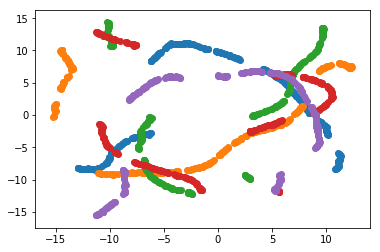

In [144]:
plt.scatter(embedding1[:,0], embedding1[:,1])
plt.scatter(embedding2[:,0], embedding2[:,1])
plt.scatter(embedding3[:,0], embedding3[:,1])
plt.scatter(embedding4[:,0], embedding4[:,1])
plt.scatter(embedding5[:,0], embedding5[:,1])